# Final Project - Training Data

This Notebook tests out different ML models and check the scores. 

The training dataset contains a total of 5933 samples. 

In [ ]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
plt.style.use('bmh')

In [ ]:
# Loading Data
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train_corrected.npy')

print(data_train.shape, labels_train.shape)

In [1]:
# Labels Encoding

labels_names = ['Nike',
                'Adidas',
                'Ford',
                'Honda',
                'General Mills',
                'Unilever',
                "McDonald's",
                'KFC',
                'Gators',
                '3M']

In [ ]:
# Counting number samples per class
vals, counts = np.unique(labels_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(data_train.shape[1])+' samples)',size=15);

In [ ]:
# Helper function for data visualization
import math

def class_visualization(label, X, t, class_names, figsize=(15,75)):

    # Index locations where class label stored in X_train
    sample_idx = np.where(t==label)[0]

    #Number of samples in class label
    N = len(sample_idx)

    # settings for grid plot
    grid_rows = math.ceil(N/10)
    grid_columns = 10

    # Plotting all images
    plt.figure(figsize=figsize)
    for i in range(N):
        plt.subplot(grid_rows, grid_columns, i+1)
        plt.imshow(X[:,sample_idx[i]].reshape(300,300,3))
        plt.axis('off')
#         plt.title(class_names[label]+'('+str(label)+'): '+str(sample_idx[i]));
        plt.title(str(label)+': '+str(sample_idx[i]));

In [ ]:
# Select the class number
class_number = 0

# Adjust the "figsize" parameter as needed
class_visualization(class_number, data_train, labels_train, labels_names, (15,120))

In [ ]:
plt.imshow(data_train[:,18].reshape(300,300,3))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from skimage.transform import resize
from sklearn.svm import SVC
#import cv2

In [ ]:
#Resizing images

from PIL import Image
import numpy as np

image_resized = []
dim = (64, 64)

for i in range(len(data_train.T)):
    image = data_train[:, i].reshape((300, 300, 3))

    # Convert RGB to BGR
    bgr_image = image[..., ::-1]

    image_pil = Image.fromarray(bgr_image.astype('uint8'))  # Convert to PIL image
    resized_pil = image_pil.resize(dim, Image.ANTIALIAS)  # Resize using Pillow's resize function

    # Convert back to BGR
    resized_bgr = np.array(resized_pil)
    resized_rgb = resized_bgr[..., ::-1]

    image_resized.append(resized_rgb)

# Convert the list of resized images to a NumPy array
image_resized = np.array(image_resized)


'''
from PIL import Image

image_resized = []
target_size = (64, 64)

for i in range(len(data_train.T)):
    image = data_train[:, i].reshape((300, 300, 3))
    pil_image = Image.fromarray(image.astype('uint8'))
    resized_image = pil_image.resize(target_size, Image.ANTIALIAS)
    image_resized.append(np.array(resized_image))

image_resized = np.array(image_resized)

'''

'''
image_resized = []
dim = (64, 64)
for i in range(len(data_train.T)):
    image = data_train[:,i].reshape((300,300,3))
    image_resized.append(cv2.resize(image, dim, interpolation = cv2.INTER_AREA))
    
image_resized = np.array(image_resized)
'''

In [ ]:
X_train, X_test, t_train, t_test = train_test_split(image_resized, labels_train, 
                                                   test_size=0.2,
                                                   stratify=labels_train,
                                                   random_state=0)
print(X_train.shape)
print(t_train.shape)
print(X_test.shape)
print(t_test.shape)

In [ ]:
# Example image
plt.imshow(X_train[5])



In [ ]:
X_train = np.array([X_train[i].flatten() for i in range (len(X_train))])
X_test = np.array([X_test[i].flatten() for i in range (len(X_test))])

print(X_train.shape)
print(X_test.shape)

---

## 1.) LDA + LOGISTIC REGRESSION (Model No.1)

In [ ]:
mod2 = Pipeline([('SCALER', StandardScaler()),
                 ('LDA', LDA(n_components=8)),
                 ('LOGRES', LogisticRegression())])
mod2.fit(X_train, t_train)



In [ ]:
pred_test2 = mod2.predict(X_test)

In [ ]:
print('LR\n')
print('Accuracy:\n',accuracy_score(t_test, pred_test2))
print ('F1_score:\n',f1_score(t_test, pred_test2, average=None))
print('Confusion matrix:\n',confusion_matrix(t_test, pred_test2))

## 2.) PCA + LOGISTIC REGRESSION (Model No. 2)

In [ ]:
N, D = np.shape(X_train)
pca = PCA(n_components=min(N,D))
pca.fit(X_train)

plt.step(range(1,min(N,D)+1),np.cumsum(pca.explained_variance_ratio_)*100)

print(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.9))
print(np.cumsum(pca.explained_variance_ratio_)[20])
plt.xlabel('Number of principal components');
plt.ylabel('% Variance explained');

In [ ]:
mod3 = Pipeline([('SCALER', StandardScaler()),
                 ('PCA', PCA(n_components=500)),
                 ('LOGREG', LogisticRegression(random_state=0, tol=0.01))]) 

In [ ]:
mod3.fit(X_train, t_train)

In [ ]:
pred_test3 = mod3.predict(X_test)

print('With PCA:')
print('Test Accuracy Score = ',accuracy_score(t_test, pred_test3))
print('Confusion matrix:')
print(confusion_matrix(t_test, Y_test))


## 3.) CNN (Model No.3)

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
X_train_full = np.load('data_train.npy').T
t_train_full = np.load('labels_train.npy')

X_train_full.shape, t_train_full.shape

In [ ]:
from sklearn.model_selection import train_test_split

# Training and Test sets
X_training, X_test, t_training, t_test = train_test_split(X_train_full, 
                                                  t_train_full, 
                                                  shuffle=True,
                                                  stratify=t_train_full,
                                                  test_size=0.15)
# Train and validation sets
X_train, X_val, t_train, t_val = train_test_split(X_training, 
                                                  t_training, 
                                                  shuffle=True,
                                                  stratify=t_training,
                                                  test_size=0.2)

X_training.shape, t_training.shape, X_train.shape, t_train.shape, X_val.shape, t_val.shape

In [ ]:
del X_train_full, t_train_full
# free up space

In [ ]:

X_training = X_training.reshape(X_training.shape[0], 300, 300, 3)/255.0

X_train = X_train.reshape(X_train.shape[0], 300, 300, 3)/255.0

X_val = X_val.reshape(X_val.shape[0], 300, 300, 3)/255.0

X_test = X_test.reshape(X_test.shape[0], 300, 300, 3)/255.0


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[300,300,3]), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(2),
    keras.layers.MaxPooling2D(2), 
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
             optimizer=keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
             metrics=['accuracy'])

In [ ]:
model.fit(X_train, t_train, epochs=2, batch_size=32,
          validation_data=(X_val, t_val),
         callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
model.evaluate(X_test, t_test)

## 4) Pre-trained CNN Model Using ResNet without Regularization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow import keras

In [ ]:
X_train_full = np.load('data_train.npy').T
t_train_full = np.load('labels_train_corrected.npy')

X_train_full.shape, t_train_full.shape

In [ ]:
from sklearn.model_selection import train_test_split

# Training and Test sets
X_training, X_test, t_training, t_test = train_test_split(X_train_full, 
                                                  t_train_full, 
                                                  shuffle=True,
                                                  stratify=t_train_full,
                                                  test_size=0.15)
# Train and validation sets
X_train, X_val, t_train, t_val = train_test_split(X_training, 
                                                  t_training, 
                                                  shuffle=True,
                                                  stratify=t_training,
                                                  test_size=0.2)

X_training.shape, t_training.shape, X_train.shape, t_train.shape, X_val.shape, t_val.shape

In [ ]:
#X_training = X_training.reshape(X_training.shape[0], 300, 300, 3)/255.0

#X_train = X_train.reshape(X_train.shape[0], 300, 300, 3)/255.0

#X_val = X_val.reshape(X_val.shape[0], 300, 300, 3)/255.0

#X_test = X_test.reshape(X_test.shape[0], 300, 300, 3)/255.0

X_training_reshaped = X_training.reshape(-1, 300, 300, 3)
X_test_reshaped = X_test.reshape(-1, 300, 300, 3)

# Reshape the input data to match the model's expected input shape
X_train_reshaped = X_train.reshape(-1, 300, 300, 3)
X_val_reshaped = X_val.reshape(-1, 300, 300, 3)

In [ ]:
base_model = keras.applications.resnet50.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [ ]:
base_model.add()

nn.Linear(numFeatures, 512),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, len(trainDS.classes))
        # nn.Softmax(dim=1)

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [ ]:
# Freeze base model
base_model.trainable = False

In [ ]:
IMG_SIZE = 150

# .Input() instantiates a Keras tensor
inputs = keras.Input(shape=(300, 300, 3))
# Input layer

inputs_resized = tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs)
# resizing input to match pretrained model

x = base_model(inputs_resized, training=False)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.

In [ ]:
inputs.shape, inputs_resized.shape, x.shape

In [ ]:
# Option 1: Pooling

# Convert features of shape `base_model.output_shape[1:]` to vectors
x_pooling = keras.layers.GlobalAveragePooling2D()(x)

x_pooling.shape

In [ ]:
# Option 2: Flattening

# Convert features of shape `base_model.output_shape[1:]` to vectors
x_flatten = keras.layers.Flatten()(x)

x_flatten.shape

In [ ]:
# A Dense classifier with 10 units and softmax activation function
outputs = keras.layers.Dense(10, activation='softmax')(x_flatten)

model = keras.Model(inputs, outputs)

In [ ]:
type(model)

In [ ]:
inputs.shape, inputs_resized.shape, x.shape, outputs.shape

In [ ]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])

model.fit(X_train_reshaped,t_train, epochs=5, batch_size=32,
          validation_data=(X_val_reshaped, t_val),
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

# Again, in practice, you would run for a lot more epochs. 
# As well as perform the necessary hyperparameter tuning.

In [ ]:
model.evaluate(X_test_reshaped, t_test)

In [ ]:
# label predictions
y_test = np.argmax(model.predict(X_test_reshaped),axis=1)

y_test.shape

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(t_test, y_test, target_names=labels_names))

## 6) Pre-trained CNN Model Using ResNet with Regularization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow import keras

tf.keras.utils.set_random_seed(
    seed=0
)

###  Data Augmentation

Tutorial on Data Augmentation:
https://www.tensorflow.org/tutorials/images/data_augmentation

In [4]:
def visualize(image, label):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title(label)
  plt.imshow(image/255.0)
    
    

def visualize_both(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented/255.)

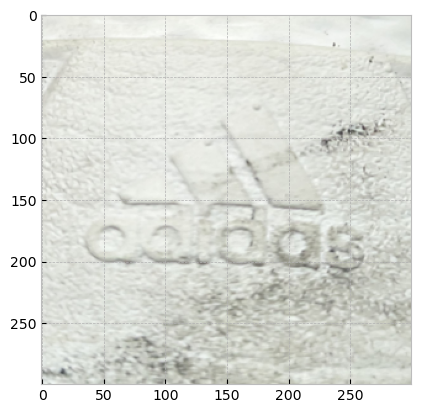

In [5]:
image = X_train[6].reshape(300,300,3)
plt.imshow(image)

In [6]:
X_train_reshaped = X_train.reshape(-1, 300, 300, 3)
X_val_reshaped = X_train.reshape(-1, 300, 300, 3)

In [7]:
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.2),
  keras.layers.RandomBrightness(0.3),
  keras.layers.RandomContrast(0.4),
  #keras.layers.RandomCrop(height=0.5,width=0.5,seed=0),
  keras.layers.RandomZoom(height_factor=0.5,width_factor=0.5,seed=0),
  #keras.layers.RandomWidth(),
])

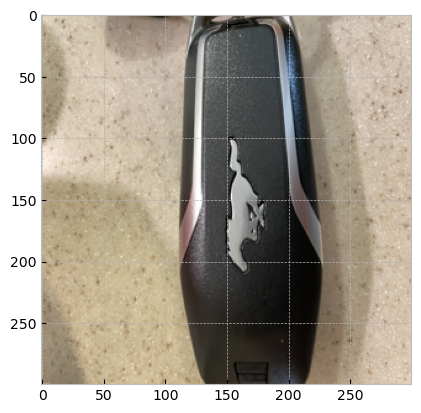

In [8]:
image = next(iter(X_train_reshaped))
_ = plt.imshow(image)

In [29]:
X_train_sample = X_train_reshaped
t_train_sample = t_train

#X_train_sample = X_train_reshaped[0,:,:,:]
#t_train_sample = t_train[0]

t_train_append = np.append(t_train_sample,t_train_sample)
t_train_append = np.append(t_train_append,t_train_sample)
t_train_append = np.append(t_train_append,t_train_sample)
t_train_append = np.append(t_train_append,t_train_sample)

t_train_append.shape

(20170,)

In [10]:
#for i in range(t_train_append.shape[0]):
#    print(t_train_append[i])

In [11]:
def return_augmented_dataset(dataset):
    augmented_dataset =data_augmentation(dataset)
    augmented_dataset_numpy = augmented_dataset.numpy()
    return augmented_dataset_numpy

In [12]:
augmented_dataset1 = return_augmented_dataset(X_train_sample)

In [13]:
augmented_dataset2 = return_augmented_dataset(X_train_sample)

In [14]:
augmented_dataset3 = return_augmented_dataset(X_train_sample)

In [15]:
augmented_dataset4 = return_augmented_dataset(X_train_sample)

In [17]:
augmented_dataset = np.append(X_train_reshaped,augmented_dataset1, axis=0)

In [18]:
augmented_dataset = np.append(augmented_dataset,augmented_dataset2, axis=0)

In [19]:
augmented_dataset = np.append(augmented_dataset,augmented_dataset3, axis=0)

In [20]:
augmented_dataset = np.append(augmented_dataset,augmented_dataset4, axis=0)

In [28]:
augmented_dataset.shape

(20170, 300, 300, 3)

# Importing / Training Model

In [3]:
X_train_full = np.load('data_train.npy').T
t_train_full = np.load('labels_train_corrected.npy')
X_train_augmented = np.load('X_train_augmented.npy')
t_train_augmented = np.load('t_train_augmented.npy')

X_train_full.shape, t_train_full.shape

((5933, 270000), (5933,))

In [4]:
from sklearn.model_selection import train_test_split

# Training and Test sets
X_training, X_test, t_training, t_test = train_test_split(X_train_full, 
                                                  t_train_full, 
                                                  shuffle=True,
                                                  stratify=t_train_full,
                                                  test_size=0.15)
# Train and validation sets
X_train, X_val, t_train, t_val = train_test_split(X_training, 
                                                  t_training, 
                                                  shuffle=True,
                                                  stratify=t_training,
                                                  test_size=0.2)

X_training.shape, t_training.shape, X_train.shape, t_train.shape, X_val.shape, t_val.shape

((5043, 270000), (5043,), (4034, 270000), (4034,), (1009, 270000), (1009,))

In [5]:
#X_training = X_training.reshape(X_training.shape[0], 300, 300, 3)/255.0

#X_train = X_train.reshape(X_train.shape[0], 300, 300, 3)/255.0

#X_val = X_val.reshape(X_val.shape[0], 300, 300, 3)/255.0

#X_test = X_test.reshape(X_test.shape[0], 300, 300, 3)/255.0

X_training_reshaped = X_training.reshape(-1, 300, 300, 3)
X_test_reshaped = X_test.reshape(-1, 300, 300, 3)

# Reshape the input data to match the model's expected input shape
X_train_reshaped = X_train.reshape(-1, 300, 300, 3)
X_val_reshaped = X_val.reshape(-1, 300, 300, 3)

In [6]:
base_model = keras.applications.resnet50.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [7]:
base_model.output_shape

(None, 5, 5, 2048)

In [8]:
#base_model.add()

In [9]:
# Freeze base model
base_model.trainable = False

In [10]:
model_seq = tf.keras.Sequential()
model_seq.add(keras.layers.Dropout(0.25))
model_seq.add(base_model)

#model_seq.add(keras.layers.Flatten())
model_seq.add(keras.layers.GlobalAveragePooling2D())

model_seq.add(keras.layers.Dropout(0.50))
model_seq.add(keras.layers.Dense(512, activation='relu'))
model_seq.add(keras.layers.Dropout(0.50))
model_seq.add(keras.layers.Dense(256, activation='relu'))
model_seq.add(keras.layers.Dropout(0.50))
model_seq.add(keras.layers.Dense(128, activation='relu'))

#model_seq.add(base_model)


In [11]:
IMG_SIZE = 150

# .Input() instantiates a Keras tensor
inputs = keras.Input(shape=(300, 300, 3))
# Input layer

inputs_resized = tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs)
# resizing input to match pretrained model

x = model_seq(inputs_resized, training=False)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.

In [12]:
# Option 1: Pooling

# Convert features of shape `base_model.output_shape[1:]` to vectors
x_pooling = keras.layers.GlobalAveragePooling2D()(x)

x_pooling.shape

ValueError: Input 0 of layer "global_average_pooling2d_1" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 128)

In [13]:
# Option 2: Flattening

# Convert features of shape `base_model.output_shape[1:]` to vectors
x_flatten = keras.layers.Flatten()(x)

x_flatten.shape

TensorShape([None, 128])

In [14]:
outputs = keras.layers.Dense(10, activation='softmax')(x_flatten)

model = keras.Model(inputs, outputs)

In [15]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])

model.fit(X_train_augmented,t_train_augmented, epochs=15, batch_size=32,
          validation_data=(X_val_reshaped, t_val),
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

# Again, in practice, you would run for a lot more epochs. 
# As well as perform the necessary hyperparameter tuning.

Epoch 1/15
631/631 [==============================] - 432s 678ms/step - loss: 0.5593 - accuracy: 0.8177 - val_loss: 0.2841 - val_accuracy: 0.9118
Epoch 2/15
631/631 [==============================] - 401s 635ms/step - loss: 0.2630 - accuracy: 0.9097 - val_loss: 0.3734 - val_accuracy: 0.8989
Epoch 3/15
631/631 [==============================] - 406s 643ms/step - loss: 0.1777 - accuracy: 0.9411 - val_loss: 0.1823 - val_accuracy: 0.9504
Epoch 4/15
631/631 [==============================] - 397s 629ms/step - loss: 0.1200 - accuracy: 0.9595 - val_loss: 0.2792 - val_accuracy: 0.9405
Epoch 5/15
631/631 [==============================] - 403s 639ms/step - loss: 0.0945 - accuracy: 0.9682 - val_loss: 0.2525 - val_accuracy: 0.9485


In [16]:
model.evaluate(X_test_reshaped, t_test)

28/28 [==============================] - 16s 577ms/step - loss: 0.1197 - accuracy: 0.9674


[0.11972300708293915, 0.9674157500267029]

In [17]:
# label predictions
y_test = np.argmax(model.predict(X_test_reshaped),axis=1)

y_test.shape

28/28 [==============================] - 18s 601ms/step


(890,)

In [18]:
from sklearn.metrics import classification_report

print(classification_report(t_test, y_test, target_names=labels_names))

               precision    recall  f1-score   support

         Nike       0.96      0.98      0.97        90
       Adidas       0.99      0.95      0.97        88
         Ford       0.99      0.98      0.98        88
        Honda       0.98      0.99      0.98        88
General_mills       0.98      0.98      0.98        90
     Unilever       0.96      1.00      0.98        91
    Mcdonalds       0.98      0.94      0.96        88
          KFC       0.99      0.92      0.95        88
       Gators       0.91      0.97      0.94        88
           3M       0.96      0.97      0.96        91

     accuracy                           0.97       890
    macro avg       0.97      0.97      0.97       890
 weighted avg       0.97      0.97      0.97       890



In [19]:
model.save('final_model.h5')